<a href="https://colab.research.google.com/github/Niilop/Super-Mario-Land-DDQN-Project/blob/main/DDQN_mario_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This is a notebook for training a double deep Q learning model to play mario on a gameboy emulator

This project is based on https://pytorch.org/tutorials/intermediate/mario_rl_tutorial.html tutorial on how to make ai learn to play mario.
Both this project and the tutorial use a gym environments with ready made game wrapper for getting information from RAM. This project uses different emulator, but includes similar code snippets from the tutorial that with more or less changes in order to fit this environment and my goals. For example the functions for learning the deep learning model and the metric logger are almost step by step from the tutorial and the environment is processed in a similar way.

The emulator used for this project is a original gameboy emulator PyBoy.

https://docs.pyboy.dk/

PyBoy can be used with an openai gym environment

https://docs.pyboy.dk/openai_gym.html

Some games in pyboy like super mario land are supported with a ready made game wrapper which gets information about the game from its RAM.

https://docs.pyboy.dk/plugins/game_wrapper_super_mario_land.html


Inspiration taken from: https://github.com/lixado/PyBoy-RL


### Requirements for the notebook

In [ ]:
%%bash
pip install tensordict==0.2.0
pip install torchrl==0.2.0
pip install gym
pip install pyboy

In [ ]:
import torch
from torch import nn
from torchvision import transforms as T
from PIL import Image
import numpy as np
from pathlib import Path
from collections import deque
import random, datetime, os

# Gym is an OpenAI toolkit for RL
import gym
from gym.spaces import Box
from gym.wrappers import FrameStack


from tensordict import TensorDict
from torchrl.data import TensorDictReplayBuffer, LazyMemmapStorage

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Custom PyBoy gym environment

Custom environment is made in order to change the action space and how the button presses are managed. PyBoy works in a way that when an action is made, a button in the emulator is pressed. The buttons also have to be released in order to make sensical movement in the game. For this, a release function has been implemented so when mario chooses DO_NOTHING action, all of the buttons are released and mario stops. The step function also includes the reward which is provided by the game wrapper.


In [ ]:
from pyboy import PyBoy
from pyboy.openai_gym import PyBoyGymEnv
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

from pyboy import WindowEvent
from gym.spaces import Discrete, MultiDiscrete, Box

class CustomEnv(PyBoyGymEnv):
    def __init__(self, *args, game_area_section=(0, 0, 32, 32), game_area_wrap_around=False, **kwargs):
        super().__init__(*args, **kwargs)


        # Flag to see if mario has respawned, used when mario dies to avoid too many minus rewards
        self.respawned = True

        self.falled = False

        # Information about last game state, used for reward function
        self.prevState = GameState(self.pyboy)

        self._DO_NOTHING = WindowEvent.PASS
        self._buttons = [
        WindowEvent.PRESS_ARROW_RIGHT,
        WindowEvent.PRESS_BUTTON_A,
        WindowEvent.PRESS_BUTTON_B
        ]

        self._buttons_release = [
        WindowEvent.RELEASE_ARROW_RIGHT,
        WindowEvent.RELEASE_BUTTON_A,
        WindowEvent.RELEASE_BUTTON_B
        ]

        self.actions = [
        [self._DO_NOTHING],
        [WindowEvent.PRESS_ARROW_RIGHT],
        [WindowEvent.PRESS_BUTTON_A],
        [WindowEvent.PRESS_ARROW_RIGHT,WindowEvent.PRESS_BUTTON_A],
        [WindowEvent.PRESS_ARROW_RIGHT,WindowEvent.PRESS_BUTTON_B],
        [WindowEvent.PRESS_ARROW_RIGHT,WindowEvent.PRESS_BUTTON_B, WindowEvent.PRESS_BUTTON_A]]

        self.action_space = Discrete(len(self.actions))

    def step(self, action_id):
        info = {}

        actions = self.actions[action_id]

        if actions[0] == self._DO_NOTHING:
            pyboy_done = self.pyboy.tick()
        else:
            for a in actions:
                self.pyboy.send_input(a)
            pyboy_done = self.pyboy.tick()

        currState = GameState(self.pyboy)

        # Time and x pos reseting happens between ticks, so if the difference is larger than 1, reset clock and x pos
        # In order to avoid big minus reward for spawning.
        # If unnaturally large change happens, the values should be equal
        if currState.time_left - self.prevState.time_left > 1 or currState.time_left - self.prevState.time_left < -1:
            self.prevState.time_left = currState.time_left

        if currState.real_x_pos  - self.prevState.real_x_pos > 10 or currState.real_x_pos  - self.prevState.real_x_pos < -10:
            self.prevState.real_x_pos = currState.real_x_pos


        # IF LIVES HAVE CHANGED MARIO SHOULD HAVE RESPAWNED
        if (currState.lives_left < self.prevState.lives_left):

            # Reset the distance
            self.prevState.real_x_pos = currState.real_x_pos
            # Reset the clock
            self.respawned = True

        currFitness = (currState.time_left) + currState.real_x_pos
        prevFitness = (self.prevState.time_left) + self.prevState.real_x_pos

        reward = currFitness - prevFitness

        # CHECK IF MARIO HAS DIED
        if (0<self.pyboy.get_memory_value(0xC0AC)<5):
            if self.respawned:
              # Since this is behind a flag and it occurs only once for every frame skip, we can just set the reward to -10000
              reward -= 100
              #print("KUOLI")
              self.respawned = False

        # CHECK IF MARIO FELL OUT OF MAP
        if (self.pyboy.get_memory_value(0xC201)>183):
            if self.respawned:
                # Since this is behind a flag and it occurs only once for every frame skip, we can just set the reward to -10000
                self.falled = True
                reward -= 100
                #print("TIPAHTI")
                self.respawned = False

        # CHECK IF TERE IS A RESPAWN TIMER
        if self.pyboy.get_memory_value(0xFFA6)  > 0:
            if self.falled:
              self.falled = not self.falled
            else:
              self.respawned = False
              reward = 0

        self.prevState = currState
        observation = self._get_observation()
        done = pyboy_done or self.game_wrapper.game_over()

        return observation, reward, done, info


    def release(self, action_id):
        actions = self.actions[action_id]

        # IF do nothing, releases all buttons
        if actions[0] == self._DO_NOTHING:
            pass
        else:
            for a in actions:
                self.pyboy.send_input(self._release_button[a])

    def reset(self):
      """ Reset (or start) the gym environment throught the game_wrapper """
      if not self._started:
          self.game_wrapper.start_game(**self._kwargs)
          self._started = True
      else:
          self.game_wrapper.reset_game()

      # Let the game run for one tick in order to update progress

      self.game_wrapper._level_progress_max = 0
      self.prevState = GameState(self.pyboy)
      self.prevState.time_left = 400
      self.button_is_pressed = {button: False for button in self._buttons}
      self.respawned = True

      return self._get_observation()

## Game state function

In [ ]:
class GameState():
  def __init__(self, pyboy):
    game_wrapper = pyboy.game_wrapper()

    self.time_left = game_wrapper.time_left
    self.lives_left = game_wrapper.lives_left
    self.score = game_wrapper.score
    self.level_progress = game_wrapper.level_progress
    self._level_progress_max = game_wrapper._level_progress_max

    # Code from https://github.com/lixado/PyBoy-RL/blob/main/AISettings/MarioAISettings.py#L10-L17
    level_block = pyboy.get_memory_value(0xC0AB)
    # C202 Mario's X position relative to the screen
    mario_x = pyboy.get_memory_value(0xC202)
    scx = pyboy.botsupport_manager().screen().tilemap_position_list()[16][0]
    real = (scx - 7) % 16 if (scx - 7) % 16 != 0 else 16
    self.real_x_pos = level_block * 16 + real + mario_x


## Wrappers for the environment.

#### SkipFrame

Not all frames need to be used for button presses so we can use a SkipFrame class to skip n frames. The reward for each frame is summed together and given to the initial button pressed.

#### ResizeObservation

The observation space can be resized for better performance in learning. PyBoy comes with a good simplified view of the screen so a rescale is not really needed. However this project uses frame stacking, so the observation space has to be transofrmed into a "box"

In [ ]:
# We dont need to act on all of the frames so we can skip them beween actions
from skimage import transform

class SkipFrame(gym.Wrapper):
    def __init__(self, env, skip):
        """Return only every `skip`-th frame"""
        super().__init__(env)
        self._skip = skip

    def step(self, action):

        """Repeat action, and sum reward"""

        total_reward = 0

        for i in range(self._skip):

            # Accumulate reward and repeat the same action
            obs, reward, done, info = self.env.step(action)

            total_reward += reward

            if done:
                break
        # Update previous state
        #self.env.prevState = GameState(self.pyboy)

        # Release pressed buttons
        self.env.release(action)

        return obs, total_reward, done,  info


class ResizeObservation(gym.ObservationWrapper):
    def __init__(self, env, shape):
        super().__init__(env)
        if isinstance(shape, int):
            self.shape = (shape, shape)
        else:
            self.shape = tuple(shape)

        obs_shape = self.shape + self.observation_space.shape[2:]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def observation(self, observation):
        observation = transform.resize(observation, self.shape)
        return observation

    def reset_modify_observation(self, modify):
        self.modify_observation = modify


## The Mario agent class

Mario class holds the act policies, information about the neural network and the functions to estimate and train the model. A cache function is used to collect limited number of steps to the agents memory, which are then used to train the deep Q learning model in batches of data. The class includes TD estimate- and target functions and the models loss backpropagation is done with update function.

I implemented functions for saving and loading the model parameters and memory data in google drive in order to train the models using checkpoints. You have to have a checkpoints folder in drive in order for this to work.

In [ ]:
from google.colab import drive
import shutil
import pickle

class Mario:
  def __init__(self, state_dim, action_dim, save_dir):
    self.state_dim = state_dim
    self.action_dim = action_dim
    self.save_dir = save_dir

    self.device = "cuda" if torch.cuda.is_available() else "cpu"

    self.net = MarioNN(self.state_dim, self.action_dim).float()
    self.net = self.net.to(device=self.device)

    self.exploration_rate = 1
    self.exploration_rate_decay = 0.99999950
    self.exploration_rate_min = 0.1
    self.curr_step = 0

    self.save_every = 1e6

    # Cache / memory
    self.memory = TensorDictReplayBuffer(storage=LazyMemmapStorage(300000,scratch_dir="/tmp/memmap/", device=self.device))
    self.batch_size = 64

    # Train parameters
    self.gamma = 0.9
    self.optimizer = torch.optim.Adam(self.net.parameters(), lr=0.00025)
    self.loss_fn = torch.nn.SmoothL1Loss()

    # Learn
    self.burnin = 1e4  # min. experiences before training
    self.learn_every = 3  # no. of experiences between updates to Q_online
    self.sync_every = 1e4  # no. of experiences between Q_target & Q_online sync

  def act(self, state):

    # Given a state, choose epsilon-greedy action and update the value of the step
    # EXPLORE epsilon greedy

    if np.random.rand() < self.exploration_rate:

      action_idx = np.random.randint(self.action_dim)

    # EXPLOIT
    else:

        state = np.array(state,dtype = float)
        state = torch.tensor(state).to(device=self.device)
        state = state.unsqueeze(0)
        action_values = self.net(state, model="online")

        action_idx = torch.argmax(action_values, dim=1).item()

    # decrease exploration_rate
    self.exploration_rate *= self.exploration_rate_decay
    self.exploration_rate = max(self.exploration_rate_min, self.exploration_rate)

    # increment step
    self.curr_step += 1
    return action_idx

    # cache(): Each time Mario performs an action, he stores the experience to his memory.
    # His experience includes the current state, action performed, reward from the action,
    # the next state, and whether the game is done.

  def cache(self, state, next_state, action, reward, done):

      state = np.array(state,dtype = float)
      next_state = np.array(next_state, dtype = float)

      state = torch.tensor(state).to(device=self.device)
      next_state = torch.tensor(next_state).to(device=self.device)
      action = torch.tensor([action]).to(device=self.device)
      reward = torch.tensor([reward]).to(device=self.device)
      done = torch.tensor([done]).to(device=self.device)

      # self.memory.append((state, next_state, action, reward, done,))
      self.memory.add(TensorDict({"state": state, "next_state": next_state, "action": action, "reward": reward, "done": done}, batch_size=[]))

  def recall(self):
      """
      Retrieve a batch of experiences from memory
      """
      batch = self.memory.sample(self.batch_size).to(self.device)
      state, next_state, action, reward, done = (batch.get(key) for key in ("state", "next_state", "action", "reward", "done"))
      return state, next_state, action.squeeze(), reward.squeeze(), done.squeeze()

  def td_estimate(self, state, action):

      current_Q = self.net(state, model="online")
      current_Q = current_Q[np.arange(0, self.batch_size), action]  # Q_online(s,a)

      return current_Q

  @torch.no_grad()
  def td_target(self, reward, next_state, done):

      next_state_Q = self.net(next_state, model="online")
      best_action = torch.argmax(next_state_Q, axis=1) # argmax_a'( Q_online(s',a') )
      next_Q = self.net(next_state, model="target")[np.arange(0, self.batch_size), best_action] # Q_target(s', argmax_a'( Q_online(s',a') ) )
      return (reward + (1 - done.float()) * self.gamma * next_Q).float() # Q*(s,a)


  def update_Q_online(self, td_estimate, td_target):

      loss = self.loss_fn(td_estimate, td_target)
      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()

      return loss.item()

  def sync_Q_target(self):
      self.net.target.load_state_dict(self.net.online.state_dict())

  def save(self):
      drive.mount('/content/drive', force_remount=True)
      save_path = (
          self.save_dir / f"mario_net2_{int(self.curr_step // self.save_every)}.chkpt"
      )
      # Saving parameters, optimizer and other information
      torch.save(
          dict(model=self.net.state_dict(),
               optimizer=self.optimizer.state_dict(),
               exploration_rate=self.exploration_rate,
               step=self.curr_step,
               memory=self.memory),
              save_path,
      )

      print(f"MarioNet saved to {save_path} at step {self.curr_step}")

      # Name of the model in drive folder
      modelname = f"mario_net2_{int(self.curr_step)}.chkpt"
      # Drive path for the model checkpoint
      drive_path = f'/content/drive/My Drive/checkpoints/{modelname}'

      # Memory folder
      tmp = f"mario_net2_{int(self.curr_step)}_tmp"
      # Drive path for the memory data
      snapshot_drive_path = f'/content/drive/My Drive/checkpoints/{tmp}'

      # Copy the model parameters to drive
      shutil.copyfile(save_path, drive_path)

      # Copy the memory directory to drive
      shutil.copytree("/tmp/memmap/", snapshot_drive_path)

  def learn(self):
      if self.curr_step % self.sync_every == 0:
          self.sync_Q_target()

      if self.curr_step % self.save_every == 0:
          self.save()

      if self.curr_step < self.burnin:
          return None, None

      if self.curr_step % self.learn_every != 0:
          return None, None

      # Sample from memory
      state, next_state, action, reward, done = self.recall()

      # Get TD Estimate
      td_est = self.td_estimate(state, action)

      # Get TD Target
      td_tgt = self.td_target(reward, next_state, done)

      # Backpropagate loss through Q_online
      loss = self.update_Q_online(td_est, td_tgt)

      return (td_est.mean().item(), loss)


  def load_model(self, model_path, Train=True):
    # Load the pre-trained model weights
    checkpoint = torch.load(model_path, map_location=self.device)
    # Model
    self.net.load_state_dict(checkpoint['model'])
    # Optimizer
    self.optimizer.load_state_dict(checkpoint['optimizer'])
    # Stepsize of the model
    self.curr_step = checkpoint['step']
    # Last exploration rate
    self.exploration_rate = checkpoint['exploration_rate']

    print("LOADING OLD MEMORY")
    self.memory = checkpoint['memory']

    # Evaluation mode
    if Train == False:
      self.net.eval()  # Set the model to evaluation mode
    # Training mode
      self.net.train()



## A simple neural network for this project

In [ ]:
import copy
class MarioNN(nn.Module):

    # Structure of the CNN, input -> (conv2d + relu x 3) -> flatten -> (dense + relu) x 2 -> output

    def __init__(self, input_dim, output_dim):
        super().__init__()
        c, h, w = input_dim

        self.online = self.__build_cnn(c, output_dim)

        self.target = copy.deepcopy(self.online)
        self.target.load_state_dict(self.online.state_dict())

        # Q_target parameters are frozen.
        for p in self.target.parameters():
            p.requires_grad = False

    def forward(self, input, model):
        if model == "online":
            return self.online(input.float())
        elif model == "target":
            return self.target(input.float())

    def __build_cnn(self, c, output_dim):
      return nn.Sequential(
          nn.Conv2d(in_channels=c, out_channels=32, kernel_size=4, stride=1),
          nn.ReLU(),
          nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=1),
          nn.ReLU(),
          nn.Conv2d(in_channels=64, out_channels=64, kernel_size=2, stride=1),
          nn.ReLU(),
          nn.Flatten(),
          nn.Linear(7488 , 512),
          nn.ReLU(),
          nn.Linear(512, 6),
        )


## MetricLogger

Taken directly from the tutorial.

https://pytorch.org/tutorials/intermediate/mario_rl_tutorial.html

In [ ]:
import numpy as np
import time, datetime
import matplotlib.pyplot as plt


class MetricLogger:
    def __init__(self, save_dir):
        self.save_log = save_dir / "log"
        with open(self.save_log, "w") as f:
            f.write(
                f"{'Episode':>8}{'Step':>8}{'Epsilon':>10}{'MeanReward':>15}"
                f"{'MeanLength':>15}{'MeanLoss':>15}{'MeanQValue':>15}"
                f"{'TimeDelta':>15}{'Time':>20}\n"
            )
        self.ep_rewards_plot = save_dir / "reward_plot.jpg"
        self.ep_lengths_plot = save_dir / "length_plot.jpg"
        self.ep_avg_losses_plot = save_dir / "loss_plot.jpg"
        self.ep_avg_qs_plot = save_dir / "q_plot.jpg"

        # History metrics
        self.ep_rewards = []
        self.ep_lengths = []
        self.ep_avg_losses = []
        self.ep_avg_qs = []
        self.ep_max_dist = []


        # Moving averages, added for every call to record()
        self.moving_avg_ep_rewards = []
        self.moving_avg_ep_lengths = []
        self.moving_avg_ep_avg_losses = []
        self.moving_avg_ep_avg_qs = []
        self.moving_avg_ep_max_dist = []

        # Current episode metric
        self.init_episode()

        # Timing
        self.record_time = time.time()

    def log_step(self, reward, loss, q):
        self.curr_ep_reward += reward
        self.curr_ep_length += 1
        if loss:
            self.curr_ep_loss += loss
            self.curr_ep_q += q
            self.curr_ep_loss_length += 1

    def log_episode(self, max_dist):
        "Mark end of episode"
        self.ep_rewards.append(self.curr_ep_reward)
        self.ep_lengths.append(self.curr_ep_length)
        # Added max distance for logging
        self.ep_max_dist.append(max_dist)

        if self.curr_ep_loss_length == 0:
            ep_avg_loss = 0
            ep_avg_q = 0
        else:
            ep_avg_loss = np.round(self.curr_ep_loss / self.curr_ep_loss_length, 5)
            ep_avg_q = np.round(self.curr_ep_q / self.curr_ep_loss_length, 5)
        self.ep_avg_losses.append(ep_avg_loss)
        self.ep_avg_qs.append(ep_avg_q)

        self.init_episode()

    def init_episode(self):
        self.curr_ep_reward = 0.0
        self.curr_ep_length = 0
        self.curr_ep_loss = 0.0
        self.curr_ep_q = 0.0
        self.curr_ep_loss_length = 0
        self.curr_level_progress = 0
        self.curr_max_dist = 0

    def record(self, episode, epsilon, step):
        mean_ep_reward = np.round(np.mean(self.ep_rewards[-100:]), 3)
        mean_ep_length = np.round(np.mean(self.ep_lengths[-100:]), 3)
        mean_ep_loss = np.round(np.mean(self.ep_avg_losses[-100:]), 3)
        mean_ep_q = np.round(np.mean(self.ep_avg_qs[-100:]), 3)
        mean_ep_max_dist = np.round(np.mean(self.ep_max_dist[-100:]), 3)

        self.moving_avg_ep_rewards.append(mean_ep_reward)
        self.moving_avg_ep_lengths.append(mean_ep_length)
        self.moving_avg_ep_avg_losses.append(mean_ep_loss)
        self.moving_avg_ep_avg_qs.append(mean_ep_q)
        self.moving_avg_ep_max_dist.append(mean_ep_max_dist)

        last_record_time = self.record_time
        self.record_time = time.time()
        time_since_last_record = np.round(self.record_time - last_record_time, 3)

        print(
            f"Episode {episode} - "
            f"Step {step} - "
            f"Epsilon {epsilon} - "
            f"Cumulative reward last 100 episodes {mean_ep_reward} - "
            f"Maximum distance reached {mean_ep_max_dist} - "
            f"Mean Length {mean_ep_length} - "
            f"Mean Loss {mean_ep_loss} - "
            f"Mean Q Value {mean_ep_q} - "
            f"Time Delta {time_since_last_record} - "
            f"Time {datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S')}"
        )

        with open(self.save_log, "a") as f:
            f.write(
                f"{episode:8d}{step:8d}{epsilon:10.3f}"
                f"{mean_ep_reward:15.3f}{mean_ep_length:15.3f}{mean_ep_loss:15.3f}{mean_ep_q:15.3f}"
                f"{time_since_last_record:15.3f}"
                f"{datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S'):>20}\n"
            )

        for metric in ["ep_lengths", "ep_avg_losses", "ep_avg_qs", "ep_rewards"]:
            plt.clf()
            plt.plot(getattr(self, f"moving_avg_{metric}"), label=f"moving_avg_{metric}")
            plt.legend()
            plt.savefig(getattr(self, f"{metric}_plot"))

## Initializing the environment



In [ ]:
from gym.wrappers import FrameStack, NormalizeObservation

game = "/content/Super Mario Land (World).gb"
pyboy = PyBoy(game, game_wrapper=True, disable_renderer=True)
pyboy.set_emulation_speed(0)

# Makes a pyboy gym environment
env = CustomEnv(pyboy, action_type='press')

# Wrappers for the game environment

# Skipping every 4 frames
env = SkipFrame(env, skip=4)
# Transform MultiDiscreate to Box for framestack
env = ResizeObservation(env, (16,20))
# Normalize observation
env = NormalizeObservation(env)
# Frame stacking: sense of movement
channels = 4
env = FrameStack(env, num_stack=channels)

# Initializes the game_wrapper which can be used to get real time information about the game
game_wrapper = pyboy.game_wrapper()

use_cuda = torch.cuda.is_available()
dim = game_wrapper.shape

# The progress is saved in a checkpoint folder
save_dir = Path("checkpoints") / datetime.datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
save_dir.mkdir(parents=True)

# Initialize the Mario agent object
mario = Mario(state_dim=(channels, dim[1], dim[0]), action_dim=env.action_space.n, save_dir=save_dir)

logger = MetricLogger(save_dir)

# FOLEDR FOR SAVED STATES
drive.mount('/content/drive')

dir = f'/content/drive/My Drive/states'
destination = '/content/states'

try:
    shutil.copytree(dir, destination)
except FileExistsError:
    print(f"The directory '{destination}' already exists.")
    shutil.copytree(dir, destination, dirs_exist_ok=True)

folder_path = '/content/states'
files = os.listdir(folder_path)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Mounted at /content/drive


## Load checkpoint files from drive

The program saves and loads files from drive (if wanted) , so the drive paths should be changed accordingly.

The checkpoint and memory files can be quite large, around 5gb so beware when loading to drive

Also paths should be changed

In [ ]:
from google.colab import drive
import shutil
'''
print(mario.curr_step)

#drive.mount('/content/drive')

# Model file path
file = "mario_net2_3903987.chkpt"
file_path = f'/content/drive/My Drive/checkpoints/{file}'

# Dump file path
dir = "mario_net2_3903987_tmp"
dir = f'/content/drive/My Drive/checkpoints/{dir}'

# Destination path in Colab
destination = '/content/'

# Copy the file1 from Google Drive to Colab
shutil.copy(file_path, destination)

# Copy the directory from Google Drive to Colab

source_dir = dir
destination_dir = "/tmp/memmap/"

try:
    shutil.copytree(dir, destination_dir)
except FileExistsError:
    print(f"The directory '{destination_dir}' already exists.")
    shutil.copytree(dir, destination_dir, dirs_exist_ok=True)


# Loading a model for further training
path = f"/content/{file}"
#path = "/content/checkpoints/2023-11-19T13-52-30/mario_net_0.chkpt"
mario.load_model(path, Train = True)

print(mario.curr_step)
print(mario.exploration_rate)
'''

0
LOADING OLD MEMORY
3903987
0.14199066147018538


In [ ]:
def loadModel(file, dir):
  pass

## Train the model!

exploration rate 0.99999975 => = 0.99999950

Memory 200000 => 300000

batch size 128 => 64 => 32 => 64

Reset on every death (game doesnt need info on respawn states + takes less time)

Normalized observation

Added checkpoints

TO DO:



Current episode  0
Episode 0 - Step 3948522 - Epsilon 0.13886382623643137 - Cumulative reward last 100 episodes 664.25 - Maximum distance reached 1591.71 - Mean Length 286.37 - Mean Loss 0.953 - Mean Q Value 22.487 - Time Delta 171.164 - Time 2023-12-11T19:25:10
Mounted at /content/drive
MarioNet saved to checkpoints/2023-12-11T08-58-33/mario_net2_3.chkpt at step 3948522


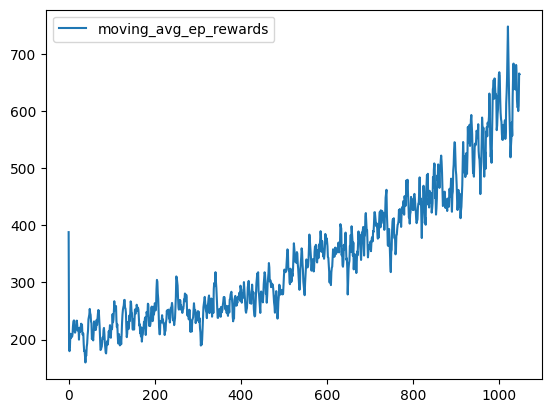

In [ ]:
from google.colab import runtime
episodes = 1
rewards = []

for e in range(episodes):
    print("Current episode ", e)

    state = env.reset()
    #game_wrapper.reset_game()
    start = time.time()

    # 50% chance to start from a checkpoint
    if random.random() > 0.5:
        random_file = random.choice(files)
        file_path = os.path.join(folder_path, random_file)
        with open(file_path, 'rb') as file_like_object:
            env.pyboy.load_state(file_like_object)

    # Play the game!
    while True:

        # Run agent on the state
        action = mario.act(state)

        # Agent performs action
        next_state, reward, done, info = env.step(action)

        # Remember
        mario.cache(state, next_state, action, reward, done)

        # Learn
        q, loss = mario.learn()

        # Logging
        logger.log_step(reward, loss, q)

        # Update state
        state = next_state

        # Check if end of game
        if done or time.time() - start > 500 or env.respawned == False:
          break

    logger.log_episode(game_wrapper._level_progress_max)

    if (e % 20 == 0) or (e == episodes - 1):
        # Log information every 20 episode
        logger.record(episode=e, epsilon=mario.exploration_rate, step=mario.curr_step)
mario.save()
#runtime.unassign()